In [2]:
import os
import numpy as np
import pandas as pd
import glob
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense,LSTM
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
#sns.set(style="darkgrid")
from keras.models import load_model

Using TensorFlow backend.


In [3]:
df = pd.read_excel("time_series.xlsx")

In [4]:
df = df.iloc[:,1:2881]

In [5]:
df = df.dropna()

In [6]:
df = df.reset_index(drop=True)

In [31]:
display(df)

,0,1,2,3,4,5,6,7,8,9,...,2870,2871,2872,2873,2874,2875,2876,2877,2878,2879
0,34.398087,34.398087,34.398087,34.398087,37.958370,37.958370,37.958370,37.958370,35.538284,35.538284,...,49.292221,49.292221,49.292221,43.439564,43.439564,43.439564,32.491669,32.491669,32.491669,32.491669
1,11.923971,11.923971,11.923971,11.923971,11.109582,11.109582,11.109582,11.109582,16.095539,16.095539,...,25.328291,25.328291,25.328291,30.823246,30.823246,30.823246,39.288010,39.288010,39.288010,39.288010
2,58.222057,58.222057,58.222057,58.222057,53.618980,53.618980,53.618980,53.618980,51.198895,51.198895,...,122.791733,122.791733,122.791733,125.047371,125.340759,125.340759,125.290382,125.290382,125.290382,125.290382
3,15.012849,15.012849,15.012849,15.012849,11.843982,11.843982,11.843982,11.843982,4.357113,4.357113,...,22.273878,22.273878,22.273878,22.045980,22.045980,22.045980,16.569902,16.569902,16.569902,16.569902
4,28.089104,28.089104,28.089104,28.089104,27.041897,27.041897,27.041897,27.041897,23.007502,23.007502,...,49.777802,49.777802,49.777802,51.152920,51.152920,51.152920,48.955788,48.955788,48.955788,48.955788
5,82.762115,82.762115,82.762115,82.762115,80.149406,80.149406,80.149406,80.149406,76.459694,76.459694,...,161.085953,161.085953,161.085953,189.291138,189.291138,189.291138,216.766022,216.766022,216.766022,216.766022
6,38.344837,38.344837,38.344837,38.344837,38.344837,0.038345,38.344837,38.344837,38.344837,38.344837,...,66.964516,66.964516,66.964516,64.905479,64.905479,64.905479,70.762062,70.762062,70.762062,70.762062
7,46.563629,46.563629,46.563629,46.563629,48.463173,48.463173,48.463173,48.463173,45.526272,45.526272,...,82.821243,82.821243,82.821243,91.866982,91.866982,91.866982,99.880157,99.880157,99.880157,99.880157
8,12.822731,12.822731,12.822731,12.822731,12.519598,12.519598,12.519598,12.519598,11.481169,11.481169,...,19.624456,19.624456,19.624456,17.622496,17.622496,17.622496,15.869956,15.869956,15.869956,15.869956
9,51.762833,51.762833,51.762833,51.762833,48.026012,48.026012,48.026012,48.026012,44.335934,44.335934,...,17.267157,17.267157,17.267157,16.872704,16.872704,16.872704,16.799774,16.799774,16.799774,16.799774


In [7]:
def isSubArray(A, B, n, m, st):
    ii = st
    j = 0
    while (ii < n and j < m): 
        if (A[ii] == B[j]): 
            ii += 1 
            j += 1 
            if (j == m): 
                return ii,True
        else: 
            ii = ii - j + 1 
            j = 0 
    return ii,False 

In [8]:
l = []
for i in df.index:
    xx = df.iloc[i][:250].values
    r = isSubArray(xx.tolist(),[0,0,0,0], 250, 4,0)
    if(r[1]):
        l.append((i, r[0]))                      # i=index, r[0]='timestamp', r[1]=fault
l = pd.DataFrame(l)

In [34]:
l

,0,1
0,15,240
1,49,196
2,60,4
3,68,44
4,72,132
5,74,72
6,77,140
7,78,162
8,91,8
9,104,104


In [9]:
df = df.drop(l[0])

In [36]:
df

,0,1,2,3,4,5,6,7,8,9,...,2870,2871,2872,2873,2874,2875,2876,2877,2878,2879
0,34.398087,34.398087,34.398087,34.398087,37.958370,37.958370,37.958370,37.958370,35.538284,35.538284,...,49.292221,49.292221,49.292221,43.439564,43.439564,43.439564,32.491669,32.491669,32.491669,32.491669
1,11.923971,11.923971,11.923971,11.923971,11.109582,11.109582,11.109582,11.109582,16.095539,16.095539,...,25.328291,25.328291,25.328291,30.823246,30.823246,30.823246,39.288010,39.288010,39.288010,39.288010
2,58.222057,58.222057,58.222057,58.222057,53.618980,53.618980,53.618980,53.618980,51.198895,51.198895,...,122.791733,122.791733,122.791733,125.047371,125.340759,125.340759,125.290382,125.290382,125.290382,125.290382
3,15.012849,15.012849,15.012849,15.012849,11.843982,11.843982,11.843982,11.843982,4.357113,4.357113,...,22.273878,22.273878,22.273878,22.045980,22.045980,22.045980,16.569902,16.569902,16.569902,16.569902
4,28.089104,28.089104,28.089104,28.089104,27.041897,27.041897,27.041897,27.041897,23.007502,23.007502,...,49.777802,49.777802,49.777802,51.152920,51.152920,51.152920,48.955788,48.955788,48.955788,48.955788
5,82.762115,82.762115,82.762115,82.762115,80.149406,80.149406,80.149406,80.149406,76.459694,76.459694,...,161.085953,161.085953,161.085953,189.291138,189.291138,189.291138,216.766022,216.766022,216.766022,216.766022
6,38.344837,38.344837,38.344837,38.344837,38.344837,0.038345,38.344837,38.344837,38.344837,38.344837,...,66.964516,66.964516,66.964516,64.905479,64.905479,64.905479,70.762062,70.762062,70.762062,70.762062
7,46.563629,46.563629,46.563629,46.563629,48.463173,48.463173,48.463173,48.463173,45.526272,45.526272,...,82.821243,82.821243,82.821243,91.866982,91.866982,91.866982,99.880157,99.880157,99.880157,99.880157
8,12.822731,12.822731,12.822731,12.822731,12.519598,12.519598,12.519598,12.519598,11.481169,11.481169,...,19.624456,19.624456,19.624456,17.622496,17.622496,17.622496,15.869956,15.869956,15.869956,15.869956
9,51.762833,51.762833,51.762833,51.762833,48.026012,48.026012,48.026012,48.026012,44.335934,44.335934,...,17.267157,17.267157,17.267157,16.872704,16.872704,16.872704,16.799774,16.799774,16.799774,16.799774


In [10]:
df = df.reset_index(drop=True)

In [38]:
df

,0,1,2,3,4,5,6,7,8,9,...,2870,2871,2872,2873,2874,2875,2876,2877,2878,2879
0,34.398087,34.398087,34.398087,34.398087,37.958370,37.958370,37.958370,37.958370,35.538284,35.538284,...,49.292221,49.292221,49.292221,43.439564,43.439564,43.439564,32.491669,32.491669,32.491669,32.491669
1,11.923971,11.923971,11.923971,11.923971,11.109582,11.109582,11.109582,11.109582,16.095539,16.095539,...,25.328291,25.328291,25.328291,30.823246,30.823246,30.823246,39.288010,39.288010,39.288010,39.288010
2,58.222057,58.222057,58.222057,58.222057,53.618980,53.618980,53.618980,53.618980,51.198895,51.198895,...,122.791733,122.791733,122.791733,125.047371,125.340759,125.340759,125.290382,125.290382,125.290382,125.290382
3,15.012849,15.012849,15.012849,15.012849,11.843982,11.843982,11.843982,11.843982,4.357113,4.357113,...,22.273878,22.273878,22.273878,22.045980,22.045980,22.045980,16.569902,16.569902,16.569902,16.569902
4,28.089104,28.089104,28.089104,28.089104,27.041897,27.041897,27.041897,27.041897,23.007502,23.007502,...,49.777802,49.777802,49.777802,51.152920,51.152920,51.152920,48.955788,48.955788,48.955788,48.955788
5,82.762115,82.762115,82.762115,82.762115,80.149406,80.149406,80.149406,80.149406,76.459694,76.459694,...,161.085953,161.085953,161.085953,189.291138,189.291138,189.291138,216.766022,216.766022,216.766022,216.766022
6,38.344837,38.344837,38.344837,38.344837,38.344837,0.038345,38.344837,38.344837,38.344837,38.344837,...,66.964516,66.964516,66.964516,64.905479,64.905479,64.905479,70.762062,70.762062,70.762062,70.762062
7,46.563629,46.563629,46.563629,46.563629,48.463173,48.463173,48.463173,48.463173,45.526272,45.526272,...,82.821243,82.821243,82.821243,91.866982,91.866982,91.866982,99.880157,99.880157,99.880157,99.880157
8,12.822731,12.822731,12.822731,12.822731,12.519598,12.519598,12.519598,12.519598,11.481169,11.481169,...,19.624456,19.624456,19.624456,17.622496,17.622496,17.622496,15.869956,15.869956,15.869956,15.869956
9,51.762833,51.762833,51.762833,51.762833,48.026012,48.026012,48.026012,48.026012,44.335934,44.335934,...,17.267157,17.267157,17.267157,16.872704,16.872704,16.872704,16.799774,16.799774,16.799774,16.799774


# faults

In [11]:
l = []
for i in df.index:
    xx = df.iloc[i][250:].values
    r = isSubArray(xx.tolist(),[0,0,0,0], len(xx), 4,0)
    if(r[1]):
        l.append((i, r[0]))
l = pd.DataFrame(l)

In [12]:
# l: 0=index, 1='timestamp', 2=fault
X_fault_indices = pd.DataFrame(zip(l[0], l[1], l[1].apply(lambda t: list(range(t-4, t+250-4))))) # l[1] is already fault-250
X_fault = []
for i in X_fault_indices.values:
    X_fault.append([i[0], list(df.iloc[i[0], i[2]])])
    
X_fault = pd.DataFrame(X_fault)                 # 0 - df index for future use
X_fault = pd.DataFrame(list(X_fault[1].values))

y is just an list of ones. test_train_split() will divide properly

# no fault
selected randomly from !l

In [13]:
mask = pd.Series(len(df) * [True])
mask[l[0]] = False
no_faults = df[mask]

In [14]:
X_no_faults = []

for i in no_faults.index:
    r = np.random.randint(df.shape[1] - 250)
    X_no_faults.append([i, list(df.iloc[i,r:r+250])])

X_no_faults = pd.DataFrame(list( pd.DataFrame(X_no_faults)[1].values ))

In [15]:
for i in range(3):
    X_no_faults = pd.concat([X_no_faults, X_no_faults])
    X_fault = pd.concat([X_fault, X_fault])

y = np.array([1]*len(X_fault) + [0]*len(X_no_faults))

X = np.array(pd.concat([X_fault, X_no_faults]))

In [16]:
X = X.reshape((X.shape[0], X.shape[1], 1))

In [17]:
X.shape

(3832, 250, 1)

In [18]:
y.shape

(3832,)

In [19]:
# Spliting into traing and testing 
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [20]:
x_train.shape,x_test.shape

((2567, 250, 1), (1265, 250, 1))

In [21]:
model = Sequential()

In [22]:
model.add(LSTM(256, input_shape=(x_train.shape[1],1))) # dropout = 0.2,recurrent_dropout=0.2,

In [23]:
model.add(Dense(1, activation='sigmoid'))

In [24]:
model.compile(loss = 'binary_crossentropy' , optimizer='adam',metrics=['accuracy'])

In [25]:
history = model.fit(x_train,y_train,epochs=50,validation_split=0.2,batch_size=3000)

Train on 2053 samples, validate on 514 samples
Epoch 1/50
2053/2053 [==============================] - 7s 3ms/step - loss: 0.6717 - acc: 0.5650 - val_loss: 0.6636 - val_acc: 0.6226
Epoch 2/50
2053/2053 [==============================] - 2s 756us/step - loss: 0.6462 - acc: 0.6449 - val_loss: 0.6756 - val_acc: 0.6167
Epoch 3/50
2053/2053 [==============================] - 2s 747us/step - loss: 0.6476 - acc: 0.6439 - val_loss: 0.6670 - val_acc: 0.6226
Epoch 4/50
2053/2053 [==============================] - 2s 761us/step - loss: 0.6382 - acc: 0.6581 - val_loss: 0.6513 - val_acc: 0.6342
Epoch 5/50
2053/2053 [==============================] - 2s 757us/step - loss: 0.6248 - acc: 0.6659 - val_loss: 0.6424 - val_acc: 0.6362
Epoch 6/50
2053/2053 [==============================] - 2s 757us/step - loss: 0.6191 - acc: 0.6615 - val_loss: 0.6441 - val_acc: 0.6537
Epoch 7/50
2053/2053 [==============================] - 2s 758us/step - loss: 0.6198 - acc: 0.6615 - val_loss: 0.6432 - val_acc: 0.6479
Epo

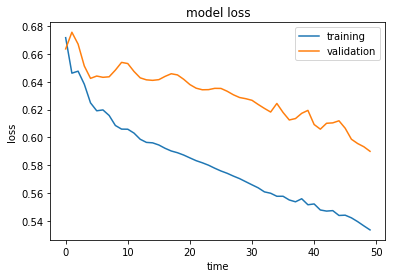

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('time')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()


0.6084924035839502


Text(0.5, 15.0, 'Predicted label')

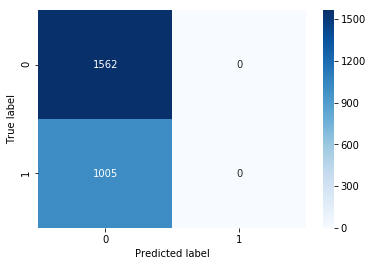

In [27]:
pred = model.predict(x_train)
predict_classes = pred.argmax(axis = 1)
# Accuracy
print(sum(predict_classes==y_train)/len(y_train))

cm = confusion_matrix(y_train,predict_classes)
sns.heatmap(confusion_matrix(y_train,predict_classes),annot=True,fmt='d',cmap="Blues") 
plt.ylabel('True label')
plt.xlabel('Predicted label')

0.5992094861660079


Text(0.5, 15.0, 'Predicted label')

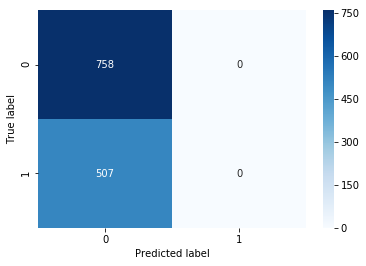

In [28]:
pred = model.predict(x_test)
predict_classes = pred.argmax(axis = 1)
# Accuracy
print(sum(predict_classes==y_test)/len(y_test))

cm = confusion_matrix(y_test,predict_classes)
sns.heatmap(confusion_matrix(y_test,predict_classes),annot=True,fmt='d',cmap="Blues") 
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [29]:
pred

array([[0.9014376 ],
       [0.6004559 ],
       [0.19855271],
       ...,
       [0.38896358],
       [0.21398894],
       [0.11604182]], dtype=float32)